In [3]:
import os, sys
import iris
import iris.plot as iplt
import numpy
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

cwd = os.getcwd()
repo_dir = '/'
for directory in cwd.split('/')[1:]:
    repo_dir = os.path.join(repo_dir, directory)
    if directory == 'ocean-analysis':
        break

modules_dir = os.path.join(repo_dir, 'modules')
sys.path.append(modules_dir)
import general_io as gio
import convenient_universal as uconv

In [4]:
numpy.cumsum([10, 20, 30, 40])

array([ 10,  30,  60, 100])

In [5]:
% matplotlib inline

In [6]:
def convert_to_joules(cube):
    """Convert units to Joules"""
    
    assert 'W' in str(cube.units)
    assert 'days' in str(cube.coord('time').units)
    
    time_span_days = cube.coord('time').bounds[:, 1] - cube.coord('time').bounds[:, 0]
    time_span_seconds = time_span_days * 60 * 60 * 24
    
    cube.data = cube.data * uconv.broadcast_array(time_span_seconds, 0, cube.shape)
    cube.units = str(cube.units).replace('W', 'J')
    
    return cube

In [10]:
def calc_change(cube):
    """Calculate change between first and last timestep."""
        
    change = cube.data[-1] - cube.data[0]
    
    return change

    
def calc_anomaly(cube):
    """Calculate the anomaly."""
    
    anomaly = cube.copy()
    anomaly.data = anomaly.data - anomaly.data[0]
    
    return anomaly


def calc_cumsum(cube):
    """Calculate the cumulative sum."""
    
    new_cube = cube.copy()
    new_cube.data = numpy.cumsum(new_cube.data)
    
    return new_cube

In [13]:
def print_results(model, experiment, mip, inferred=False, window=1, plot=False):
    """Get the data files"""

    time_constraint = gio.get_time_constraint(['1861-01-01', '2005-12-31'])
    insert = '-inferred-' if inferred else '-'
        
    ohc_globe_file = '/g/data/r87/dbi599/DRSv2/CMIP5/%s/%s/yr/ocean/%s/ohc/latest/dedrifted/ohc-globe-sum_Oyr_%s_%s_%s_all.nc' %(model, experiment, mip, model, experiment, mip)
    hfds_file = '/g/data/r87/dbi599/DRSv2/CMIP5/%s/%s/yr/ocean/%s/hfds/latest/hfds%ssum-hemispheric-metrics_Oyr_%s_%s_%s_all.nc' %(model, experiment, mip, insert, model, experiment, mip)
    
    ohc_globe_cube = iris.load_cube(ohc_globe_file, 'ocean heat content globe sum' & time_constraint)
    hfds_globe_cube_W = iris.load_cube(hfds_file, 'Downward Heat Flux at Sea Water Surface globe sum' & time_constraint)
    
    hfds_globe_cube_J = convert_to_joules(hfds_globe_cube_W)
    
    if window > 1:
        ohc_globe_cube = ohc_globe_cube.rolling_window('time', iris.analysis.MEAN, window)
        hfds_globe_cube_J = hfds_globe_cube_J.rolling_window('time', iris.analysis.MEAN, window)
    
    ohc_anomaly = calc_anomaly(ohc_globe_cube)
    hfds_anomaly = calc_anomaly(hfds_globe_cube_J)
    hfds_cumsum = calc_cumsum(hfds_anomaly)
    
    if plot:
        iplt.plot(ohc_anomaly, label='OHC')
        iplt.plot(hfds_cumsum, label='hfds')
        plt.legend()
        plt.show()
            
    ohc_change = calc_change(ohc_anomaly)
    print('OHC change:', ohc_change)
    print('hfds accumulated:', hfds_anomaly.data.sum())

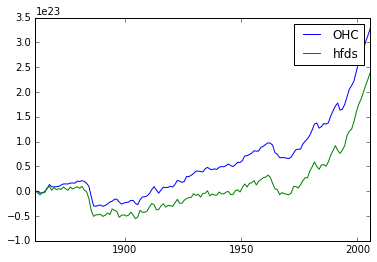

OHC change: 3.28155447301e+23
hfds accumulated: 2.392877613e+23


In [14]:
print_results('CanESM2', 'historical', 'r1i1p1', inferred=True, plot=True)

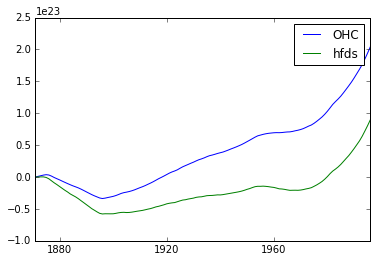

OHC change: 2.03924261912e+23
hfds accumulated: 8.95008227248e+22


In [15]:
print_results('CanESM2', 'historical', 'r1i1p1', inferred=True, window=20, plot=True)

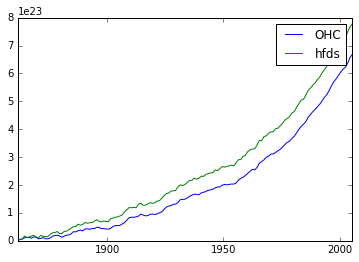

OHC change: 6.68632731466e+23
hfds accumulated: 7.78630222378e+23


In [16]:
print_results('CanESM2', 'historicalGHG', 'r1i1p1', inferred=True, plot=True)

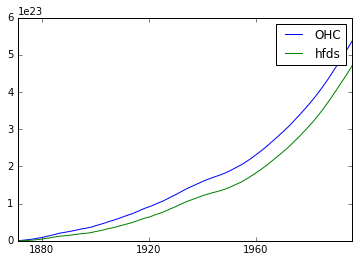

OHC change: 5.38189048564e+23
hfds accumulated: 4.71397980742e+23


In [17]:
print_results('CanESM2', 'historicalGHG', 'r1i1p1', inferred=True, window=20, plot=True)

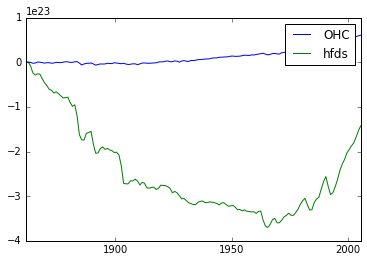

OHC change: 6.06995359294e+22
hfds accumulated: -1.42369620337e+23


In [18]:
print_results('CCSM4', 'historical', 'r1i1p1', plot=True)

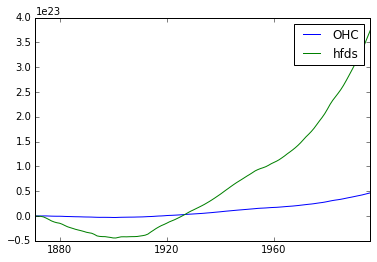

OHC change: 4.66401357994e+22
hfds accumulated: 3.7410628748e+23


In [19]:
print_results('CCSM4', 'historical', 'r1i1p1', window=20, plot=True)

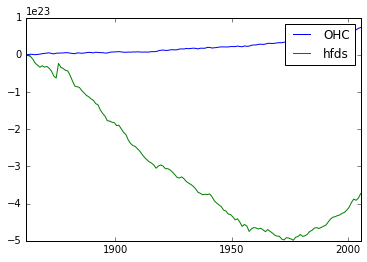

OHC change: 7.34620247965e+22
hfds accumulated: -3.72792208472e+23


In [20]:
print_results('CCSM4', 'historicalGHG', 'r1i1p1', plot=True)

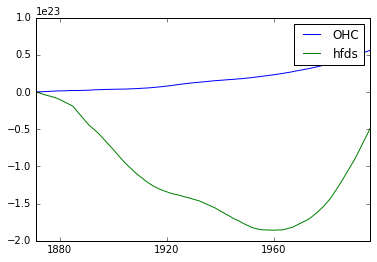

OHC change: 5.61874765359e+22
hfds accumulated: -4.82772003169e+22


In [21]:
print_results('CCSM4', 'historicalGHG', 'r1i1p1', window=20, plot=True)

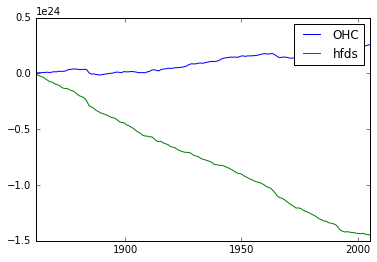

OHC change: 2.61082296387e+23
hfds accumulated: -1.45324200678e+24


In [22]:
print_results('CSIRO-Mk3-6-0', 'historical', 'r1i1p1', plot=True)

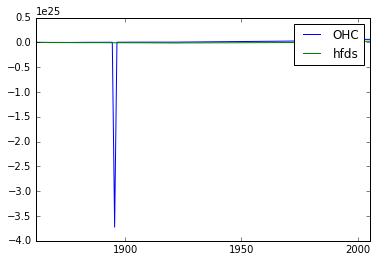

OHC change: 6.2723911789e+23
hfds accumulated: 2.44960490373e+23


In [23]:
print_results('CSIRO-Mk3-6-0', 'historicalGHG', 'r1i1p1', plot=True)

In [25]:
hfds_hist_file = '/g/data/r87/dbi599/DRSv2/CMIP5/CanESM2/historical/yr/ocean/r1i1p1/hfds/latest/hfds-inferred-sum-hemispheric-metrics_Oyr_CanESM2_historical_r1i1p1_all.nc' 
hfds_control_file = '/g/data/r87/dbi599/DRSv2/CMIP5/CanESM2/piControl/yr/ocean/r1i1p1/hfds/latest/hfds-inferred-sum-hemispheric-metrics_Oyr_CanESM2_piControl_r1i1p1_all.n' 
